## Belief Dynamics on the Social Network 

- This notebook explores various more generic implications of the social-network-based learning in _Learning from Friends in a Pandemic_ by Christos Makridis and Tao Wang. These results are not included in the paper.

In [10]:
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
#%matplotlib inline


In [11]:
## figures configurations
plt.style.use('seaborn')
plt.rcParams["font.family"] = "Times New Roman" #'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['axes.labelweight'] = 'bold'

## Set the 
plt.rc('font', size=25)
# Set the axes title font size
plt.rc('axes', titlesize=20)
# Set the axes labels font size
plt.rc('axes', labelsize=20)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=20)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=20)
# Set the legend font size
plt.rc('legend', fontsize=20)
# Set the font size of the figure title
plt.rc('figure', titlesize=20)
plt.rc('lines', linewidth=4)

In [12]:
## load SCI weight matrix 

W = np.load('SCIWeight.npy')
W16 =  np.load('SCIWeight16.npy')

N = W.shape[0]
N16 = W16.shape[0]

## IRFs with social network learning 

- plots the impulse response of average beliefs about the aggregate state following 
  - aggregate/fundamental-relevant shock
  - idiosyncratic/news shocks 
    - in different locations
    - under different networks

In [13]:
##############################################################
## analytical function of IRFs to an aggregate shock and idiosyncratic shocks
#########################################################################

def irf_ag(k,
           λ,
           W, ## listening matrix 
           v): ## steps of IRF
    """
    this is to operate on matrix, very slow. 
    actually it is not a function of W. So can use irf_ag_simple functions.
    but i still include it for comparison purpose 
    """
    
    N = len(W)
    H = np.ones(N)
    Iκ = (1-k)*H   ## I-\kappa
    X0 = 1/N*k*(1-λ)
    M = (1-λ)*np.diag(Iκ)+λ*W
    irf = 0.0
    for s in range(v+1):
        Ms = np.linalg.matrix_power(M,s)
        #########
        HMsH = Ms.sum()
        #############
        Xs = X0*HMsH
        irf = irf+Xs
    return irf

def irf_ag_simple(k,
                  λ,
                  v):
    x0 = k*(1-λ)
    rho =(1-λ)*(1-k)+λ  ## this is the summary statistic of the average belief 
    irf = 0.0
    for s in range(v+1):
        xv = x0*(rho)**s
        irf = irf+xv
    return irf

def irf_id_c(k,
             λ, 
             W,  ## listening matrix 
             v,  ## steps of IRF
             Z): ## new addition, a vector of 1/0s deciding if the shock hit there
    
    N = len(W)
    H = np.ones(N)
    
    Iκ = (1-k)*H
    X0 =1/N*k*(1-λ)
    M = (1-λ)*np.diag(Iκ)+λ*W
    Mv = np.linalg.matrix_power(M,v)
    #####
    ## different for ag and id
    HMvZ = H@Mv@Z
    ######
    Xv = X0*HMvZ
    irf = Xv
    return irf

#### How does aggregate IRF depends on k and $\lambda$

#### The time path of the IRF

In [16]:
k_fix = 0.33
k_vals = np.array([0.3,0.5,0.9])
λ_vals = np.array([0.01,0.3,0.8,0.99])
v_vals = np.arange(10)

In [17]:
IRF_ag_path = np.empty((len(k_vals),len(λ_vals), len(v_vals)))
                       
for j,k in enumerate(k_vals):
    for i, λ in enumerate(λ_vals):
        for t, v in enumerate(v_vals):
            IRF_ag_path[j,i,t] = irf_ag_simple(k,
                                              λ,
                                              v)

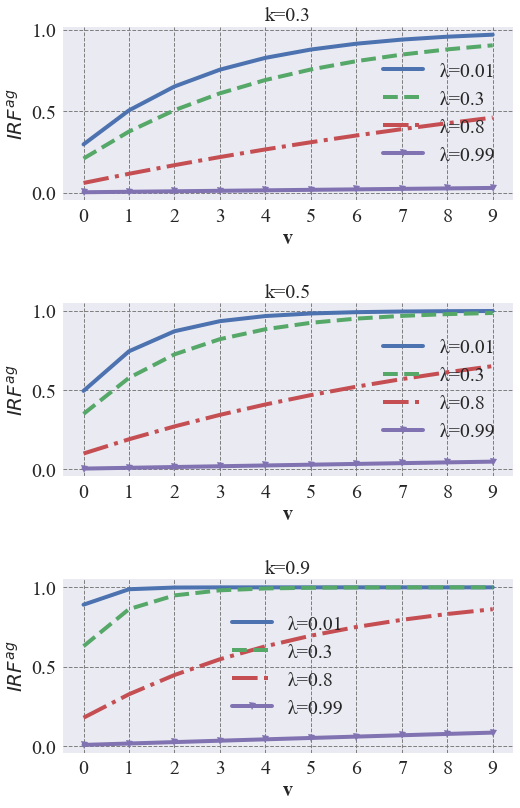

In [30]:
lp_ls=['-','--','-.','v-']
nb_plots = len(k_vals)

fig,ax =plt.subplots(nb_plots,1,figsize=(8,12))
ax = ax.ravel()

for j,k in enumerate(k_vals):
    for i,λ in enumerate(λ_vals):
        ax[j].plot(IRF_ag_path[j,i,:],
                lp_ls[i],
               label =r'λ={}'.format(λ))
        ax[j].set_xlabel('v')
        ax[j].set_ylabel(r'$IRF^{ag}$')
        ax[j].set_title(r'k={}'.format(k))
        ax[j].set_xticks(v_vals)
        ax[j].grid('major',color='gray', linestyle='--', linewidth=1)
        ax[j].legend(loc=0)
fig.tight_layout(pad=1.4)
plt.savefig('../graph/model/IRF_ag_path.jpg')

#### How does idiosyncratic IRF depends on k and $\lambda$

- we assume the shocks happen at the top x fraction of influenial nodes 

In [20]:
def where_to_shock(W,
                  where):  # a tuple, for instance (0.0,0.33) represents the top third influencers to be hit
    N = len(W)
    Z = np.zeros(N)
    degree = np.sum(W,axis = 0)
    rank_idx = np.flip(degree.argsort())  ## descending sorted index, e.g. the first element is the index of smallest influence
    lb,ub = where
    cut_lb,cut_ub = np.int(N*lb),np.int(N*ub),
    shocked_idx = rank_idx[cut_lb:cut_ub-1]
    Z[shocked_idx] = 1
    return Z 

In [21]:
## generate Z vectors 
Z_top = where_to_shock(W,
                      (0.0,0.33))
Z_mid = where_to_shock(W,
                      (0.33,0.66))
Z_bot = where_to_shock(W,
                      (0.66,0.99))

/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_44613/3368330790.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_lb,cut_ub = np.int(N*lb),np.int(N*ub),


#### Time path of IRF to local shocks to the top

In [24]:
k_fix = 0.33
k_vals = np.array([0.3,0.5,0.9])
λ_vals = np.array([0.01,0.3,0.8,0.99])
v_vals = np.arange(10)

In [25]:
IRF_id_path = np.empty((len(k_vals),len(λ_vals), len(v_vals)))
                       
for j,k in enumerate(k_vals):
    for i, λ in enumerate(λ_vals):
        for t, v in enumerate(v_vals):
            IRF_id_path[j,i,t] = irf_id_c(k=k,
                                          λ=λ,
                                          W=W,
                                          v=v,
                                          Z = Z_top)

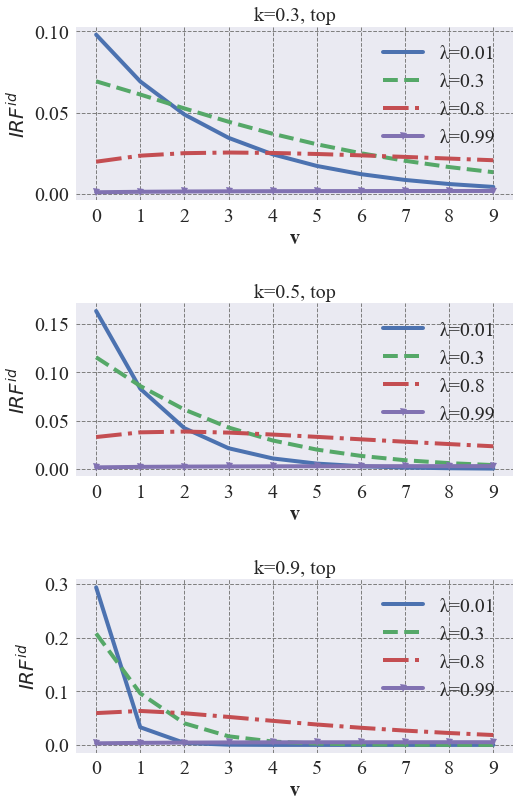

In [29]:
lp_ls=['-','--','-.','v-']
nb_plots = len(k_vals)
#b_lim =-0.1 ## y axis range lower lim
#t_lim = 0.6  ## y axis range upper lim

fig,ax =plt.subplots(nb_plots,1,figsize=(8,12))
ax = ax.ravel()

for j,k in enumerate(k_vals):
    for i,λ in enumerate(λ_vals):
        ax[j].plot(IRF_id_path[j,i,:],
                lp_ls[i],
               label =r'λ={}'.format(λ))
        ax[j].set_xlabel('v')
        ax[j].set_ylabel(r'$IRF^{id}$')
        ax[j].set_title(r'k={}, top'.format(k))
        ax[j].set_xticks(v_vals)
        ax[j].grid('major',color='gray', linestyle='--', linewidth=1)
        ax[j].legend(loc=0)
        #ax[j].set_ylim(b_lim, t_lim)
fig.tight_layout(pad=1.4)
plt.savefig('../graph/model/IRF_id_path_top.jpg')

#### Time path of IRF to local shocks to the bottom

In [27]:
k_fix = 0.33
k_vals = np.array([0.3,0.5,0.9])
λ_vals = np.array([0.01,0.3,0.8,0.99])
v_vals = np.arange(10)

IRF_id_path_bot = np.empty((len(k_vals),len(λ_vals), len(v_vals)))
                       
for j,k in enumerate(k_vals):
    for i, λ in enumerate(λ_vals):
        for t, v in enumerate(v_vals):
            IRF_id_path_bot[j,i,t] = irf_id_c(k=k,
                                          λ=λ,
                                          W=W,
                                          v=v,
                                          Z = Z_bot)

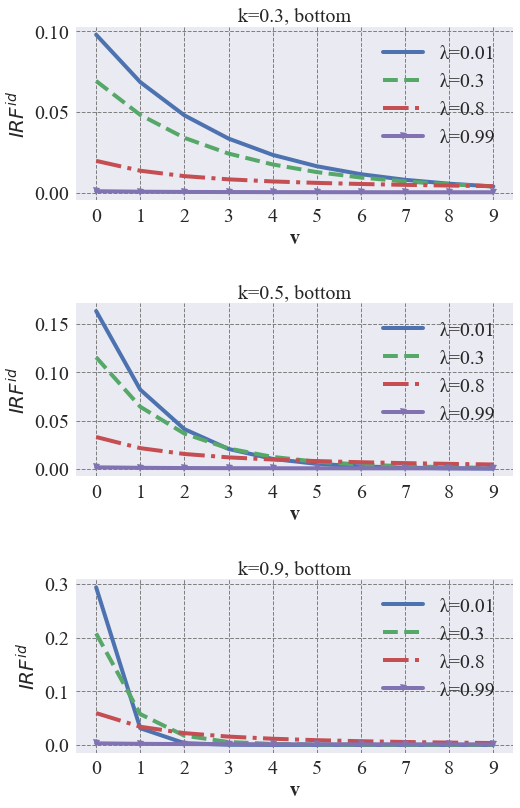

In [31]:
lp_ls=['-','--','-.','v-']
nb_plots = len(k_vals)

#b_lim =-0.3 ## y axis range lower lim
#t_lim = 0.6  ## y axis range upper lim

fig,ax =plt.subplots(nb_plots,1,figsize=(8,12))
ax = ax.ravel()

for j,k in enumerate(k_vals):
    for i,λ in enumerate(λ_vals):
        ax[j].plot(IRF_id_path_bot[j,i,:],
                lp_ls[i],
               label =r'λ={}'.format(λ))
        ax[j].set_xlabel('v')
        ax[j].set_ylabel(r'$IRF^{id}$')
        ax[j].set_title(r'k={}, bottom'.format(k))
        ax[j].set_xticks(v_vals)
        ax[j].grid('major',color='gray', linestyle='--', linewidth=1)
        ax[j].legend(loc=0)
        #ax[j].set_ylim(b_lim, t_lim)
fig.tight_layout(pad=1.4)
plt.savefig('../graph/model/IRF_id_path_bot.jpg')

### How does IRF depend on network structure 

In [32]:
autarky = np.identity(N)
egal = np.ones((N,N))*1/N

In [33]:
## different networks 
W_ls = [W,
        autarky,
        egal]
labels_ls =['Actual','Autarky','Egalitarian']

IRF_ids_ls=[]

## compute IRFs 

grid_size = 20

k_vals = np.linspace(0.001, 2.00, grid_size)
λ_vals = np.linspace(0.001, 0.99, grid_size)


for s,weight in enumerate(W_ls):
    IRF_ids = np.empty((grid_size, grid_size))
    for i, k in enumerate(k_vals):
        for j, λ in enumerate(λ_vals):
            IRF_ids[i, j] = irf_id_c(k=k,
                                     λ=λ,
                                     W=weight,
                                     v=1,
                                     Z = Z_top)
    # foreach weight matrix 
    IRF_ids_ls.append(IRF_ids)

/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_44613/15738296.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(cs1, ax=ax)


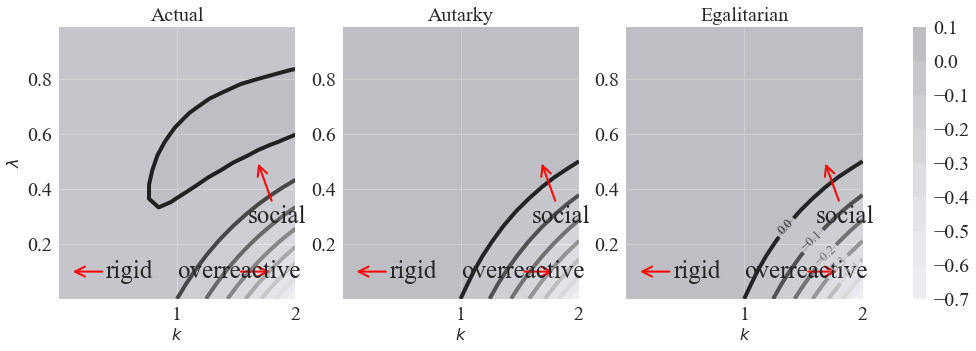

In [34]:
## plot 
fig, ax = plt.subplots(1,3,figsize=(18,5))

ax = ax.ravel()

for plt_id in range(len(W_ls)):
    IRF_ids_this = IRF_ids_ls[plt_id]
    cs1 = ax[plt_id].contourf(k_vals, λ_vals, IRF_ids_this.T, alpha=0.2)
    ctr1 = ax[plt_id].contour(k_vals, λ_vals, IRF_ids_this.T)


    ax[plt_id].set_title(str(labels_ls[plt_id]))
    ax[plt_id].set_xlabel("$k$", fontsize=16)
    ax[0].set_ylabel("$λ$", fontsize=16)

    ax[plt_id].ticklabel_format(useOffset=False)


    ax[plt_id].annotate('overreactive', xy=(1.8,0.1),
                xytext=(1.0,0.1), va='center', multialignment='right',
                arrowprops={'arrowstyle': '->', 'lw': 2, 'ec': 'r'})
    
    ax[plt_id].annotate('rigid', xy=(0.1,0.1),
                xytext=(0.4,0.1), va='center', multialignment='right',
                arrowprops={'arrowstyle': '->', 'lw': 2, 'ec': 'r'})

    ax[plt_id].annotate('social', xy=(1.68,0.5),
                xytext=(1.6,0.3), va='center', multialignment='right',
                arrowprops={'arrowstyle': '->', 'lw': 2, 'ec': 'r'})

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)
plt.savefig('../graph/model/IRF_id_W_compare.jpg')

In [35]:
## time path 
Z_top_16 = where_to_shock(W16,
                          (0.0,0.33))

/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_44613/3368330790.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_lb,cut_ub = np.int(N*lb),np.int(N*ub),


In [36]:
k_fix = 0.33
k_vals = np.array([0.3,0.5,0.9])
λ_vals = np.array([0.01,0.3,0.8,0.99])
v_vals = np.arange(10)

In [37]:
IRF_id_path_16 = np.empty((len(k_vals),len(λ_vals), len(v_vals)))
                       
for j,k in enumerate(k_vals):
    for i, λ in enumerate(λ_vals):
        for t, v in enumerate(v_vals):
            IRF_id_path_16[j,i,t] = irf_id_c(k=k,
                                             λ=λ,
                                             W=W16,
                                             v=v,
                                             Z = Z_top_16)
            

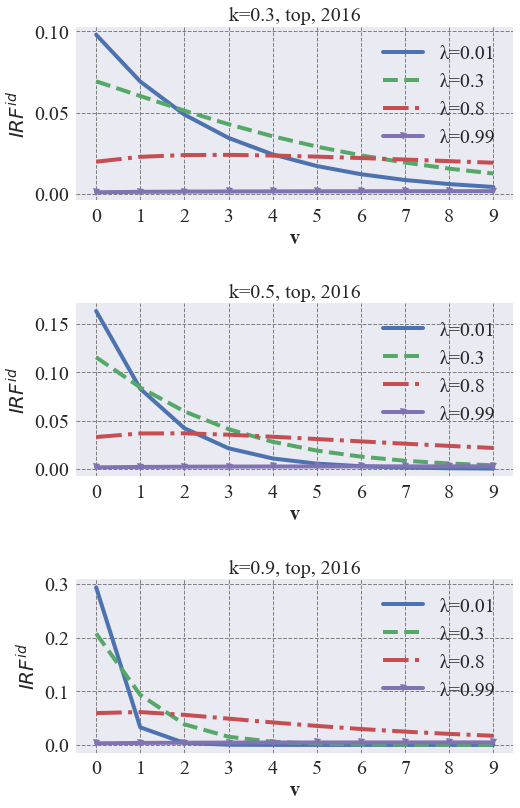

In [39]:
lp_ls=['-','--','-.','v-']
nb_plots = len(k_vals)
#b_lim =0.0 ## y axis range lower lim
#t_lim = 0.6  ## y axis range upper lim

fig,ax =plt.subplots(nb_plots,1,figsize=(8,12))
ax = ax.ravel()

for j,k in enumerate(k_vals):
    for i,λ in enumerate(λ_vals):
        ax[j].plot(IRF_id_path_16[j,i,:],
                lp_ls[i],
               label =r'λ={}'.format(λ))
        ax[j].set_xlabel('v')
        ax[j].set_ylabel(r'$IRF^{id}$')
        ax[j].set_title(r'k={}, top, 2016'.format(k))
        ax[j].set_xticks(v_vals)
        ax[j].grid('major',color='gray', linestyle='--', linewidth=1)
        ax[j].legend(loc=0)
        #ax[j].set_ylim(b_lim, t_lim)
fig.tight_layout(pad=1.4)
plt.savefig('../graph/model/IRF_id_path_top_2016.jpg')